In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [127]:
df = pd.read_csv("../data/car_sales_date_company_ohe.csv")

In [128]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

le = LabelEncoder()
df['Company'] = le.fit_transform(df['Company'])

In [129]:
# for datatype reasons
df = df.drop('Date', axis=1)

# for model reasons
X = df[['Company', 'Year', 'Month', 'Day']]
# X = df.drop(columns=['Sales_Count', 'Total_Sales'])

y = df['Sales_Count']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [130]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
    }

    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse

In [131]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best Hyperparameters:", study.best_params)

best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE: {rmse}")

[I 2025-02-06 20:27:29,795] A new study created in memory with name: no-name-5218518e-466b-4295-bb31-032b504576d2
/var/folders/p2/kz7q7x7x42g49d80lqbllfy00000gn/T/ipykernel_32533/223840243.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/p2/kz7q7x7x42g49d80lqbllfy00000gn/T/ipykernel_32533/223840243.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
/var/folders/p2/kz7q7x7x42g49d80lqbllfy00000gn/T/ipykernel_32533/223840243.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

Best Hyperparameters: {'n_estimators': 197, 'max_depth': 14, 'learning_rate': 0.05616409041508267, 'subsample': 0.8204157097166362, 'colsample_bytree': 0.7803618431570631, 'reg_alpha': 8.954306628157687, 'reg_lambda': 0.0016583292068409377}
Final RMSE: 1.4684271126520259


In [132]:
plot_df = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})
plot_df = pd.concat([plot_df, X_test], axis=1)

# create new column called date based on the year, month and day columns
plot_df['Date'] = pd.to_datetime(plot_df[['Year', 'Month', 'Day']])

# get date column on nice format
plot_df['Date'] = plot_df['Date'].dt.strftime('%Y-%m-%d')

# sort the values based on the date
plot_df = plot_df.sort_values(by='Date')

plot_df

,y_test,y_pred,Company,Year,Month,Day,Date
19,1,1.196740,26,2022,1,2,2022-01-02
14,1,1.341483,17,2022,1,2,2022-01-02
10,1,1.100942,10,2022,1,2,2022-01-02
3,1,1.148610,3,2022,1,2,2022-01-02
8,2,1.943443,8,2022,1,2,2022-01-02
...,...,...,...,...,...,...,...
10482,1,2.862454,18,2023,12,31,2023-12-31
10487,2,2.566827,27,2023,12,31,2023-12-31
10483,2,1.993010,21,2023,12,31,2023-12-31
10479,1,1.865939,15,2023,12,31,2023-12-31


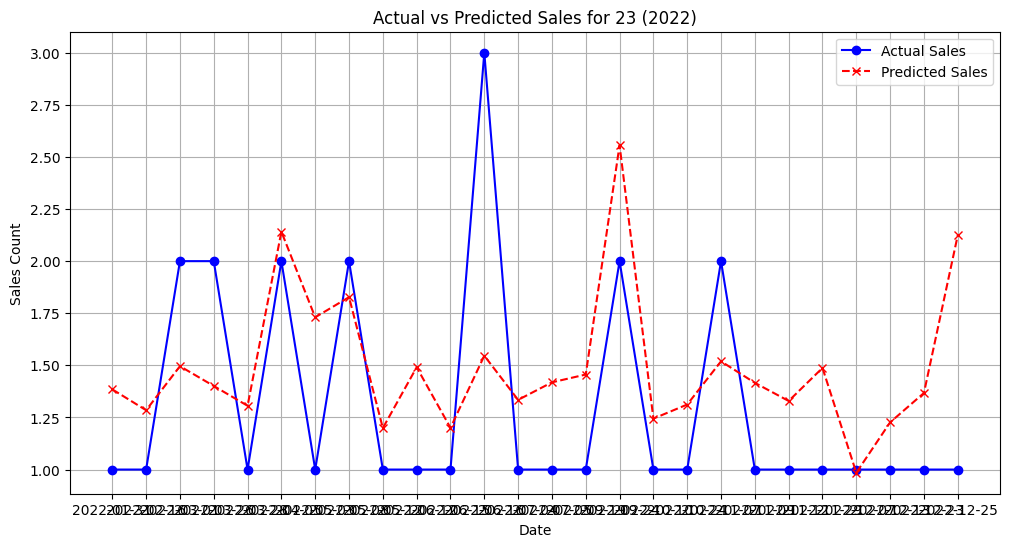

In [137]:
company_number = 23

# Filter data for the specific company and year 2022
company_df = plot_df[(plot_df['Company'] == company_number)
                     & (plot_df['Year'] == 2022)]

# Get the actual sales count
actual_sales = company_df['y_test']

# Get the predicted sales count
predicted_sales = company_df['y_pred']

# Get the dates
dates = company_df['Date']

plt.figure(figsize=(12, 6))
plt.plot(dates, actual_sales, label="Actual Sales",
         marker="o", linestyle="-", color="blue")
plt.plot(dates, predicted_sales, label="Predicted Sales",
         marker="x", linestyle="--", color="red")
plt.xlabel("Date")
plt.ylabel("Sales Count")
plt.title(f"Actual vs Predicted Sales for {company_number} (2022)")
plt.legend()
plt.grid()
plt.show()